# Clasificación de señales de tráfico italianas aplicando redes neuronales

Se pretende desarrollar un clasificador de señales de tráfico italianas aplicando redes neuronales. El software deberá dividirse en cuatro partes claramente diferenciadas:

    1.-Preparación del dataset: crear la estructura de carpetas y los archivos adicionales que sean necesarios para procesar el dataset.
    
    2.-Definición de la red neuronal: definir las capas que compondrán la red neuronal. Se valora de forma muy positiva que se construya la red neuronal capa a capa y no se empleen clases de frameworks de deep learning que ya traen ciertas redes implementadas (por ejemplo, en el caso de Keras, el paquete applications).
    
    3.-Entrenamiento de la red neuronal.
    
    4.-Predicción: definir un método que tenga como parámetro de entrada la ruta a una imagen alojada en el equipo y como salida el tipo de señal de tráfico que la red neuronal ha predicho (identificador numérico y descripción).

### Carga de librerías y creación de funciones

In [156]:
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [157]:
def show_img_labl(img, label):
    imshow(img) 
    print(CLASSES[CLASSES["Class"]==int(label)])

In [158]:
# lectura del fichero classes
CLASSES = pd.read_table("Images/classes.txt", sep = "=", names=["Class","Description"])

In [159]:
# Función para visualización cómoda de imágenes y etiquetas 
def display_label_images(images, labels):
    
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))

    for index in range(limit):
        plt.subplot(3, 8, index+1)  # 3 rows, 8 per row
        plt.axis('off')
        description = CLASSES.get_value(int(labels[index]),"Description")
        plt.title("Clase:{0}".format(labels[index]))
        plt.imshow(images[index])
    plt.show() 
    

In [160]:
# Ejemplo de asociación de clase
CLASSES[CLASSES["Class"]==10]

,Class,Description
10,10,direction type0 (mandatory)


## Parte 1: Preparación del dataset:

El dataset de clasificación de señales italianas se ha descargado de: http://www.dis.uniroma1.it/~bloisi/ds/dits.html.

Este sigue una estructura de carpetas. Por un lado tenemos la carpeta correspondiente al conjunto de datos de entrenamiento, denotada como **/train**, y de forma equivalente, se tiene **/test** para el conjunto de test. En el archivo classes.py se tiene una descripción de las diferentes clases que sigue la siguiente regla:
        # = className (superclass) 

    

Tanto **/train** como **/test**, contienen una serie de subcarpetas. Cada subcarpeta contiene imágenes de señales del mismo tipo. En total existen 47 clases para el test y 59 para el entrenamiento.

La primera tarea será extraer los archivos de imágenes de esta estructura de subcarpetas y crear un conjunto de datos de tipo train/test en los que se incluyan las imágenes como atributos y la carpeta a la que pertenecen como variable de salida.

Para hacer más entendible el proceso, se ha creado un Dataframe para las imágenes de train y test. Ambos tienen una columna en la que se indica la ruta en la que se encuentra la imagen y otra en la que se especifica la clase a la que pertenece, que es extraida de la carpeta en la que se ubica. Se podría haber creado directamente el numpy array resultante de la lectura de las imagenes, pero el objetivo es ilustrar paso a paso el procedimiento.


In [161]:
# Ruta relativa de las carpetas
TEST_PATH = "Images/test"
TRAIN_PATH = "Images/train"

# Definición de las listas en las que se almacenan las rutas y clases a las que pertenecen 
# las imagenes

train_image_path = []
train_image_label = []
test_image_path = []
test_image_label = []

##################
# CONJUNTO TRAIN #
##################

# Carpetas que determinan la clase de las imágenes que alojan en su interior
# Examples (/0, /1,.../58)
train_subfolders =  [subfolder for subfolder in os.listdir(TRAIN_PATH)]

for train_class in train_subfolders:
    
    # Example (Images/train/0, /1,.../58)
    sub_path0 = TRAIN_PATH +"/"+ train_class
    
    # Subcarpetas dentro de cada icategoría de imagen (15 imágenes por subcarpeta)
    # Example (/track0,/track1)
    train_subfolders1 =  [subfolder for subfolder in os.listdir(sub_path0)]
    
    for sub_folder1 in train_subfolders1:
        # Example (Images/train/0/track0, Images/train/0/track1)
        sub_path1 = sub_path0 +"/"+sub_folder1
        # Ruta de las imágenes dentro de las subcarpetas
        image_path = [image for image in os.listdir(sub_path1)]
        
        for img_path in image_path:
            # Ruta completa de cada imagen
            train_image_path.append(sub_path1+"/"+img_path)
            # Clase a la que pertenece cada imagen
            train_image_label.append(train_class)
            

#################
# CONJUNTO TEST #
#################

# Examples (/0, /1,.../58)
test_subfolders =  [subfolder for subfolder in os.listdir(TEST_PATH)]

for test_class in test_subfolders:
    # Example (Images/test/0, /1,.../58)
    test_sub_path0 = TEST_PATH +"/"+ test_class
    # Ruta de las imágenes dentro de las subcarpetas
    image_path = [image for image in os.listdir(test_sub_path0)]
    
    for img_path in image_path:
        # Ruta completa de cada imagen
        test_image_path.append(test_sub_path0+"/"+img_path)
        # Clase a la que pertenece cada imagen
        test_image_label.append(test_class)
    
##############
# DATAFRAMES #
##############

test_data = {"Path":test_image_path, "Label":test_image_label }
test = pd.DataFrame(test_data)    

train_data = {"Path":train_image_path, "Label":train_image_label }
train = pd.DataFrame(train_data)  

full_input = {"Path":test_image_path + train_image_path , "Label":test_image_label + train_image_label}
all_data = pd.DataFrame(full_input)


### Visualización de los dataframes:

En este punto se visualiza el contenido de ambos dataframes para hacernos una idea de la estructura de los datos

In [162]:
# Primeros 10 datos de train
train.head(10)

,Label,Path
0,0,Images/train/0/track0/2015-11-26 12-36-40.221....
1,0,Images/train/0/track0/2015-11-26 12-36-40.221....
2,0,Images/train/0/track0/2015-11-26 12-36-40.221....
3,0,Images/train/0/track0/2015-11-26 12-36-40.221....
4,0,Images/train/0/track0/2015-11-26 12-36-40.221....
5,0,Images/train/0/track0/2015-11-26 12-36-40.221....
6,0,Images/train/0/track0/2015-11-26 12-36-40.221....
7,0,Images/train/0/track0/2015-11-26 12-36-40.221....
8,0,Images/train/0/track0/2015-11-26 12-36-40.221....
9,0,Images/train/0/track0/2015-11-26 12-36-40.221....


In [163]:
# Primeros 10 datos de test
test.head(10)

,Label,Path
0,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
1,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
2,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
3,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
4,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
5,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
6,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
7,10,Images/test/10/2016-01-04 13-58-48.429.wmv_024...
8,10,Images/test/10/2016-01-04 13-58-48.429.wmv_025...
9,10,Images/test/10/2016-01-04 13-58-48.429.wmv_025...


### Conversión de las imágenes a estructura numpy.

Una vez capturadas las rutas en las que se alojan la imágenes hay que estandarizar sus dimensiones y convertirlas a un vector para que puedan ser tratadas por la red neuronal.

Se propone su conversión a un formato 32 x 32 x 3.

Se guardarán en X_train y X_test respectivamente. Las salidas serán extraidas directamente de las variables train["Label"] y test["label"] .

### Consideración:

Como existen menos clases en los datos test que en train, se va a proceder a unir los dos conjutos de datos en uno solo, y posteriormente separarlos mediante estratificación de las variables

In [164]:
# Ejecutar solamente si se quiere reestructurar los datos.
images = []

for path in all_data["Path"]:
    image = misc.imread(path)
    images.append(misc.imresize(image, [32,32,3], interp='bilinear', mode=None))

X = np.asarray(images)
y = np.asarray(all_data["Label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

In [327]:
# Ejecutar solamente si se quiere conservar la estructura de train test inicial
images_train= []
images_test= []

for path in train["Path"]:
    image = misc.imread(path)
    images_train.append(misc.imresize(image, [32,32,3], interp='bilinear', mode=None))
for path in test["Path"]:
    image = misc.imread(path)
    images_test.append(misc.imresize(image, [32,32,3], interp='bilinear', mode=None))
    
X_train = np.asarray(images_train)
y_train = np.asarray(train["Label"])
X_test = np.asarray(images_test)
y_test = np.asarray(test["Label"])

    Class          Description
21     21   give way (warning)


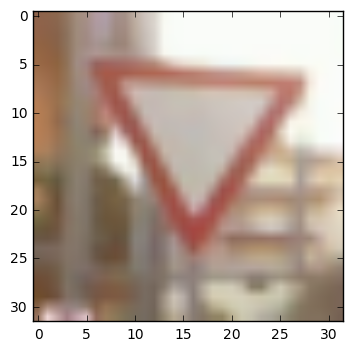

In [37]:
# Ejemplo de una imagen cualquiera tras el reshape
show_img_labl(X_test[100], y_test[100])


### Preprocesado de datos:

    1. Aleatorizar la posición de los datos
    2. Normalizar y escalar todas las características
    3. Realizar una codificación One-Hot para las etiquetas correspondientes a las clases

Los diferentes test que se van a usar son extraidos del repositorio proporcionado como ayuda para el ejercicio: https://github.com/udacity/CarND-Keras-Lab/blob/master/traffic-sign-classification-with-keras-solution.ipynb.

Este, en concreto, comprueba que no se ha cambiado el shape durante el proceso de aleatorizado

### 1. Aleatorizar

In [165]:
# 1. Aleatorizar
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

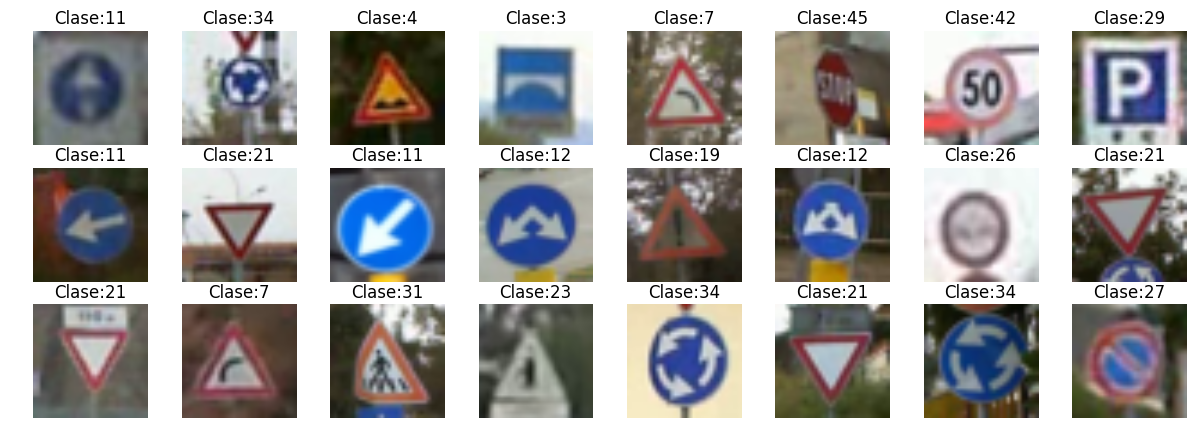

In [167]:
# Muestra d las 25 primeras imágenes después de randomizar
display_label_images(X_train, y_train)

### 2. Normalizar

In [168]:
# 2. Normalizar y escalar. Se pasan los datos a escala normalizada
def normalize_scale(image_data):
    a = -0.5
    b = 0.5
    scale_min = 0
    scale_max = 255
    return a + ( ( (image_data - scale_min)*(b - a) )/( scale_max - scale_min ) )

X_normalized = normalize_scale(X_train)
X_normalized_test = normalize_scale(X_test)

In [169]:
# Verfica que la normalización se ha realizado correctamente
assert math.isclose(np.min(X_normalized), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_normalized), 0.5, 
                   abs_tol=1e-5), 'The range of the training data is: {} to {}.  It must be -0.5 to 0.5'.format(np.min(X_normalized), np.max(X_normalized))
print('Tests passed.')

Tests passed.


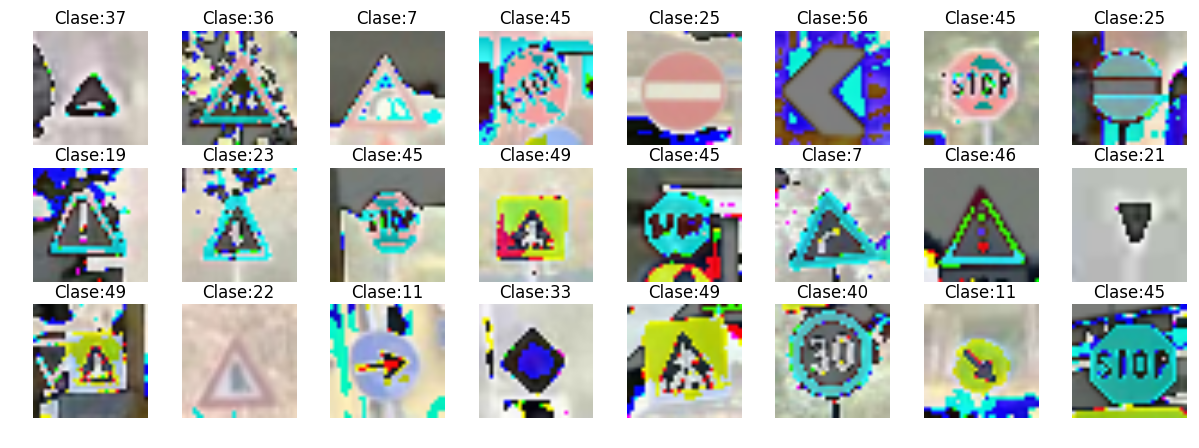

In [33]:
# Muestra d las 25 primeras imágenes después de normalizar
display_label_images(X_normalized, y_train)

### 3. Codificar One-Hot:

Para adecuar la variable respuesta al formato que usa la red neuronal es necesario realizar una codificación one-hot. Consiste en generar tantas columnas como categorías haya y colocar un uno en la categoría correspondiente.

Ejemplo con 3 categorías:

    Cat = 1 ----> [1 0 0]
    Cat = 2 ----> [0 1 0]
    Cat = 3 ----> [0 0 1]
    
Como la variable respuesta del conjunto de test tiene menos categorías que las del conjunto de entrenamiento, hay que etrenar la función de binarización con la y_train (que contiene todas las categorías), y aplicar la transformación a y_test

In [170]:
# 3. Codificación One-hot
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit(y_train)
y_one_hot_test = label_binarizer.transform(y_test)

In [171]:
# Comprobación que hace la binarización correcta. Para ello se hace la operación opuesta y se comprueba el resultado.
# Se ve que las clases coinciden
a = y_one_hot_test
b= label_binarizer.inverse_transform(a)
print(b[0:550:15],  "|", y_test[0:550:15])

['21' '12' '12' '21' '27' '31' '22' '25' '41' '49' '12' '40' '40' '21' '32'
 '49' '11' '23' '21' '11' '40' '22' '37' '50' '4' '6' '34' '34' '45' '27'
 '45' '37' '3' '14' '29' '30' '3'] | ['21' '12' '12' '21' '27' '31' '22' '25' '41' '49' '12' '40' '40' '21' '32'
 '49' '11' '23' '21' '11' '40' '22' '37' '50' '4' '6' '34' '34' '45' '27'
 '45' '37' '3' '14' '29' '30' '3']


In [172]:
# Número de elementos y categorías diferentes para los conjuntos de train y test.
aux = np.unique(y_train)
print("Train: Tamaño = {0} - Categorías = {1} | Test: Tamaño = {2} - Categorías = {3}"\
      .format(len(y_train), len(np.unique(y_train)),len(y_test), len(np.unique(y_test))))
      

Train: Tamaño = 6486 - Categorías = 59 | Test: Tamaño = 2162 - Categorías = 59


In [173]:

# Verifica que se cumple la codificación 
import collections
assert y_one_hot.shape == (len(X_train), 59), 'y_one_hot is not the correct shape.  It\'s {}, it should be (5794, 59)'.format(y_one_hot.shape)
assert next((False for y in y_one_hot if collections.Counter(y) != {0: 58, 1: 1}), True), 'y_one_hot not one-hot encoded.'
print('Tests passed.')

Tests passed.


## Parte 2: Definición de la red neuronal.

Se crearán varios modelos de redes, añadiendo progresivamente capas y se verá la evolución de la precisión de las redes genedas.

In [174]:
# Librerías necesarias
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

### Red multicapa feedforward

In [181]:
# Creación del modelo feedforward
model = Sequential()

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten(input_shape=(32, 32, 3)))

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(59, activation="softmax"))

Una vez definidas las capas se compila el modelo. Para una salida categórica multivariable se utiliza la función de pérdida 'categorical_crossentropy'. Esta necesita que para más de 10 categorías en la variable de salida, se haga una codificación one-hot.

Como algoritmo de ajuste de pesos se usará adam. (Adaptive Moment Estimation)


In [182]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=10, validation_split=0.20, verbose=2)

Train on 5188 samples, validate on 1298 samples
Epoch 1/10
2s - loss: 2.1556 - acc: 0.4678 - val_loss: 1.4580 - val_acc: 0.6094
Epoch 2/10
1s - loss: 0.9834 - acc: 0.7328 - val_loss: 0.9868 - val_acc: 0.7173
Epoch 3/10
2s - loss: 0.6480 - acc: 0.8238 - val_loss: 0.7969 - val_acc: 0.7720
Epoch 4/10
1s - loss: 0.4615 - acc: 0.8774 - val_loss: 0.7442 - val_acc: 0.7935
Epoch 5/10
1s - loss: 0.3644 - acc: 0.9077 - val_loss: 0.6965 - val_acc: 0.8028
Epoch 6/10
1s - loss: 0.2729 - acc: 0.9333 - val_loss: 0.5788 - val_acc: 0.8382
Epoch 7/10
2s - loss: 0.2240 - acc: 0.9458 - val_loss: 0.6717 - val_acc: 0.8097
Epoch 8/10
1s - loss: 0.1786 - acc: 0.9595 - val_loss: 0.5931 - val_acc: 0.8344
Epoch 9/10
2s - loss: 0.1439 - acc: 0.9699 - val_loss: 0.6127 - val_acc: 0.8313
Epoch 10/10
2s - loss: 0.1246 - acc: 0.9719 - val_loss: 0.5596 - val_acc: 0.8490


In [183]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2112/2162 [============================>.] - ETA: 0s

[0.54593382176153094, 0.85337650307232749]

### Red convolucional:

Son especialmente eficaces en el tratamiento de imágenes, sobre todo para tareas de clasificación.

Se componen de una serie de capas de diferentes propósitos, desde la la fase de extracción de características, compuesta de neuronas convolucionales y de reducción de muestreo, hasta la capa que permite la clasificación final, compuesta por neuronas de perceptron sencillas.

Esta red parte de la idea de la feedforward, pero añade una capa de convolución a la entrada, juto con su función de activación correspondiente.

In [184]:
# Creación del modelo convolucional
model = Sequential()

# Capa de convilución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(59,activation="softmax"))

In [185]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
18s - loss: 1.8598 - acc: 0.5530 - val_loss: 1.0544 - val_acc: 0.7088
Epoch 2/20
17s - loss: 0.5857 - acc: 0.8435 - val_loss: 0.6523 - val_acc: 0.8112
Epoch 3/20
17s - loss: 0.2530 - acc: 0.9316 - val_loss: 0.5261 - val_acc: 0.8405
Epoch 4/20
17s - loss: 0.1238 - acc: 0.9738 - val_loss: 0.4455 - val_acc: 0.8752
Epoch 5/20
17s - loss: 0.0508 - acc: 0.9902 - val_loss: 0.5045 - val_acc: 0.8690
Epoch 6/20
17s - loss: 0.0349 - acc: 0.9938 - val_loss: 0.4745 - val_acc: 0.8767
Epoch 7/20
18s - loss: 0.0358 - acc: 0.9934 - val_loss: 0.4494 - val_acc: 0.8891
Epoch 8/20
17s - loss: 0.0260 - acc: 0.9946 - val_loss: 0.4418 - val_acc: 0.8937
Epoch 9/20
17s - loss: 0.0228 - acc: 0.9956 - val_loss: 0.4615 - val_acc: 0.8898
Epoch 10/20
17s - loss: 0.0309 - acc: 0.9927 - val_loss: 0.5543 - val_acc: 0.8659
Epoch 11/20
17s - loss: 0.0328 - acc: 0.9915 - val_loss: 0.4916 - val_acc: 0.8867
Epoch 12/20
17s - loss: 0.0363 - acc: 0.9907 - val_loss: 0.

In [186]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 1s     


[0.49622243091422691, 0.90518038858427807]

### Pooling:

Es una mejora sobre la red convolucional anterior, en la que se le añade una capa de pooling. Permite una reducción del muestreo que ocurre dentro de la red convolucional y permite añadir cierta tolerancia a la red "resumiendo" información correspondiente a la región capturada tras la convulución. Esta capa se situa inmediatamente después de la de convolución.

La operación de max-pooling encuentra el valor máximo entre una ventana de muestra y pasa este valor como resumen de características sobre esa área. Como resultado, el tamaño de los datos se reduce por un factor igual al tamaño de la ventana de muestra sobre la cual se opera.

In [191]:
# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(59, activation="softmax"))

In [192]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
8s - loss: 2.2910 - acc: 0.4466 - val_loss: 1.2939 - val_acc: 0.6633
Epoch 2/20
7s - loss: 0.8297 - acc: 0.7808 - val_loss: 0.7584 - val_acc: 0.7720
Epoch 3/20
7s - loss: 0.4310 - acc: 0.8786 - val_loss: 0.5574 - val_acc: 0.8413
Epoch 4/20
7s - loss: 0.2558 - acc: 0.9325 - val_loss: 0.5483 - val_acc: 0.8351
Epoch 5/20
7s - loss: 0.1583 - acc: 0.9593 - val_loss: 0.4254 - val_acc: 0.8814
Epoch 6/20
7s - loss: 0.1137 - acc: 0.9744 - val_loss: 0.3958 - val_acc: 0.8883
Epoch 7/20
7s - loss: 0.0726 - acc: 0.9840 - val_loss: 0.4309 - val_acc: 0.8867
Epoch 8/20
7s - loss: 0.0666 - acc: 0.9855 - val_loss: 0.4205 - val_acc: 0.8883
Epoch 9/20
7s - loss: 0.0452 - acc: 0.9915 - val_loss: 0.3878 - val_acc: 0.8960
Epoch 10/20
7s - loss: 0.0380 - acc: 0.9927 - val_loss: 0.4333 - val_acc: 0.8906
Epoch 11/20
7s - loss: 0.0195 - acc: 0.9975 - val_loss: 0.4450 - val_acc: 0.9006
Epoch 12/20
7s - loss: 0.0278 - acc: 0.9952 - val_loss: 0.3538 - val_a

El hecho de que la precisión el conjunto test sea del 100% puede ser un indicativo de que el modelo está sobreajustado. Una posible solución sería añadir una capa dropout que favorece la capacidad de generalización

In [193]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 1s     


[0.33088139896035523, 0.91998149866753431]

### Dropout:

El dropout es una técnica que favorece el poder de generalización de la red, emulando un entrenamiento promediado entre varias redes “ficticias”, mediante la anulación, según cierta probabilidad, de neuronas de la red. Estas anulaciones emulan cambios en la arquitectura que facilita que las neuronas no se especialicen en profundidad en ciertas características del problema, debiendo ocupar el papel de otras cuando éstas son anuladas, favoreciendo la generalización.


In [195]:
# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

# Capa de dropout
model.add(Dropout(0.4))

# Capa de aplanado
model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(59, activation="softmax"))


In [196]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
8s - loss: 2.2914 - acc: 0.4505 - val_loss: 1.3195 - val_acc: 0.6572
Epoch 2/20
8s - loss: 0.9046 - acc: 0.7479 - val_loss: 0.8482 - val_acc: 0.7542
Epoch 3/20
8s - loss: 0.5214 - acc: 0.8533 - val_loss: 0.6082 - val_acc: 0.8236
Epoch 4/20
7s - loss: 0.3412 - acc: 0.9007 - val_loss: 0.4599 - val_acc: 0.8644
Epoch 5/20
7s - loss: 0.2279 - acc: 0.9375 - val_loss: 0.4811 - val_acc: 0.8529
Epoch 6/20
7s - loss: 0.1765 - acc: 0.9524 - val_loss: 0.4061 - val_acc: 0.8790
Epoch 7/20
7s - loss: 0.1378 - acc: 0.9638 - val_loss: 0.4295 - val_acc: 0.8821
Epoch 8/20
7s - loss: 0.1376 - acc: 0.9618 - val_loss: 0.3720 - val_acc: 0.9022
Epoch 9/20
7s - loss: 0.0889 - acc: 0.9765 - val_loss: 0.3741 - val_acc: 0.8921
Epoch 10/20
7s - loss: 0.0665 - acc: 0.9857 - val_loss: 0.3909 - val_acc: 0.8906
Epoch 11/20
7s - loss: 0.0619 - acc: 0.9844 - val_loss: 0.4446 - val_acc: 0.8875
Epoch 12/20
8s - loss: 0.0719 - acc: 0.9807 - val_loss: 0.4671 - val_a

In [197]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 1s     


[0.3304912481977364, 0.92414431060275803]

### Investigación de nuevas estructuras más complejas:

En el siguiente apartado se irán probando nuevas estructuras añadiendo mas capas a las anteriormente propuestas

In [198]:
# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(8, 4, 4, input_shape=(32, 32, 3), activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

# Capa de dropout para favorecer la capacidad de generalización
model.add(Dropout(0.25))

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(16, 4, 4, activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

# Capa de dropout para favorecer la capacidad de generalización
model.add(Dropout(0.5))

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo

model.add(Dense(512, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(59, activation="softmax"))


In [199]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
5s - loss: 2.8956 - acc: 0.2625 - val_loss: 1.9883 - val_acc: 0.4676
Epoch 2/20
7s - loss: 1.6218 - acc: 0.5360 - val_loss: 1.2913 - val_acc: 0.6055
Epoch 3/20
6s - loss: 1.1805 - acc: 0.6444 - val_loss: 0.8766 - val_acc: 0.7627
Epoch 4/20
8s - loss: 0.9401 - acc: 0.7097 - val_loss: 0.7403 - val_acc: 0.7989
Epoch 5/20
5s - loss: 0.7716 - acc: 0.7552 - val_loss: 0.6001 - val_acc: 0.8344
Epoch 6/20
4s - loss: 0.6931 - acc: 0.7747 - val_loss: 0.5326 - val_acc: 0.8382
Epoch 7/20
4s - loss: 0.5951 - acc: 0.8071 - val_loss: 0.4486 - val_acc: 0.8729
Epoch 8/20
4s - loss: 0.5771 - acc: 0.8034 - val_loss: 0.4313 - val_acc: 0.8798
Epoch 9/20
4s - loss: 0.5203 - acc: 0.8333 - val_loss: 0.3877 - val_acc: 0.8844
Epoch 10/20
4s - loss: 0.4812 - acc: 0.8443 - val_loss: 0.3546 - val_acc: 0.9060
Epoch 11/20
4s - loss: 0.4170 - acc: 0.8604 - val_loss: 0.3254 - val_acc: 0.9068
Epoch 12/20
4s - loss: 0.4014 - acc: 0.8709 - val_loss: 0.3022 - val_a

In [200]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 1s     


[0.21671180184465333, 0.94264569842738211]

In [205]:
# Creación del modelo convolucional con pooling
model = Sequential()

model.add(Convolution2D(32, 4, 4, input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation="relu"))

model.add(Dense(59, activation="softmax"))

In [206]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
21s - loss: 2.3420 - acc: 0.3938 - val_loss: 1.3454 - val_acc: 0.6233
Epoch 2/20
19s - loss: 0.9848 - acc: 0.7074 - val_loss: 0.7309 - val_acc: 0.7951
Epoch 3/20
13s - loss: 0.5727 - acc: 0.8182 - val_loss: 0.4435 - val_acc: 0.8636
Epoch 4/20
13s - loss: 0.3881 - acc: 0.8747 - val_loss: 0.4140 - val_acc: 0.8698
Epoch 5/20
13s - loss: 0.2966 - acc: 0.9082 - val_loss: 0.2895 - val_acc: 0.9176
Epoch 6/20
13s - loss: 0.2218 - acc: 0.9254 - val_loss: 0.2490 - val_acc: 0.9337
Epoch 7/20
13s - loss: 0.1970 - acc: 0.9356 - val_loss: 0.2217 - val_acc: 0.9345
Epoch 8/20
13s - loss: 0.1759 - acc: 0.9464 - val_loss: 0.2432 - val_acc: 0.9322
Epoch 9/20
13s - loss: 0.1342 - acc: 0.9568 - val_loss: 0.1978 - val_acc: 0.9492
Epoch 10/20
14s - loss: 0.1226 - acc: 0.9576 - val_loss: 0.2089 - val_acc: 0.9445
Epoch 11/20
17s - loss: 0.1049 - acc: 0.9684 - val_loss: 0.1684 - val_acc: 0.9507
Epoch 12/20
13s - loss: 0.1063 - acc: 0.9661 - val_loss: 0.

In [207]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 2s     


[0.14699798677492262, 0.9588344125809436]

In [212]:
# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(16, 4, 4, input_shape=(32, 32, 3),activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Convolution2D(32, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# Aplica la función de activación relu a la salida de la capa
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(59, activation="softmax"))


In [213]:
# TODO: Compile and train the model here.
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
11s - loss: 2.3878 - acc: 0.3695 - val_loss: 1.4746 - val_acc: 0.5986
Epoch 2/20
10s - loss: 1.0356 - acc: 0.6804 - val_loss: 0.8951 - val_acc: 0.7111
Epoch 3/20
10s - loss: 0.6262 - acc: 0.8034 - val_loss: 0.5945 - val_acc: 0.8220
Epoch 4/20
10s - loss: 0.4171 - acc: 0.8655 - val_loss: 0.5077 - val_acc: 0.8559
Epoch 5/20
10s - loss: 0.3001 - acc: 0.9013 - val_loss: 0.3806 - val_acc: 0.8883
Epoch 6/20
10s - loss: 0.2113 - acc: 0.9254 - val_loss: 0.3349 - val_acc: 0.8960
Epoch 7/20
10s - loss: 0.1761 - acc: 0.9424 - val_loss: 0.3483 - val_acc: 0.9076
Epoch 8/20
10s - loss: 0.1398 - acc: 0.9576 - val_loss: 0.3043 - val_acc: 0.9206
Epoch 9/20
10s - loss: 0.1347 - acc: 0.9562 - val_loss: 0.2830 - val_acc: 0.9206
Epoch 10/20
10s - loss: 0.0933 - acc: 0.9711 - val_loss: 0.2810 - val_acc: 0.9322
Epoch 11/20
10s - loss: 0.1227 - acc: 0.9616 - val_loss: 0.2466 - val_acc: 0.9414
Epoch 12/20
10s - loss: 0.0697 - acc: 0.9790 - val_loss: 0.

In [214]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 1s     


[0.17979102737677802, 0.95004625346901017]

In [209]:
# Creación del modelo convolucional con pooling
model = Sequential()

model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(59, activation="softmax"))

In [210]:
# TODO: Compile and train the model here.
model.compile("adam", 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 5188 samples, validate on 1298 samples
Epoch 1/20
55s - loss: 2.2092 - acc: 0.4426 - val_loss: 1.1430 - val_acc: 0.7065
Epoch 2/20
61s - loss: 0.8846 - acc: 0.7485 - val_loss: 0.6237 - val_acc: 0.7982
Epoch 3/20
55s - loss: 0.4839 - acc: 0.8506 - val_loss: 0.3936 - val_acc: 0.8883
Epoch 4/20
47s - loss: 0.3084 - acc: 0.9077 - val_loss: 0.3598 - val_acc: 0.9037
Epoch 5/20
47s - loss: 0.2082 - acc: 0.9370 - val_loss: 0.3183 - val_acc: 0.9168
Epoch 6/20
47s - loss: 0.1741 - acc: 0.9408 - val_loss: 0.2957 - val_acc: 0.9176
Epoch 7/20
47s - loss: 0.1347 - acc: 0.9561 - val_loss: 0.2573 - val_acc: 0.9307
Epoch 8/20
47s - loss: 0.1188 - acc: 0.9618 - val_loss: 0.2513 - val_acc: 0.9353
Epoch 9/20
47s - loss: 0.1062 - acc: 0.9686 - val_loss: 0.2801 - val_acc: 0.9245
Epoch 10/20
47s - loss: 0.0805 - acc: 0.9724 - val_loss: 0.2559 - val_acc: 0.9407
Epoch 11/20
47s - loss: 0.0885 - acc: 0.9722 - val_loss: 0.2379 - val_acc: 0.9399
Epoch 12/20
47s - loss: 0.0686 - acc: 0.9800 - val_loss: 0.

In [211]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

2162/2162 [==============================] - 5s     


[0.24054034615442102, 0.94403330249768735]

## Parte 4: Predicción

Definir un método que tenga como parámetro de entrada la ruta a una imagen alojada en el equipo y como salida el tipo de señal de tráfico que la red neuronal ha predicho (identificador numérico y descripción).

In [215]:
def predict(rutas):
    
    image = []
    description = []
    predicted_class = []
    
    for ruta in rutas:
        img = misc.imread(ruta)
        image.append(misc.imresize(img, [32,32,3], interp='bilinear', mode=None))
        
    X_predict = np.asarray(image)
    X_predict_normalized = normalize_scale(X_predict)

    predictions = model.predict(X_predict_normalized)
    labels = label_binarizer.inverse_transform(predictions)

    
    for label in labels:
        description.append(CLASSES.get_value(int(label),"Description"))
        predicted_class.append(CLASSES.get_value(int(label),"Class"))
    
    results = {"Clase predicha": predicted_class, "Descripción":description, "Ruta":rutas}
    output = pd.DataFrame(results) 
    
    return output

In [217]:
# Ejemplo dos rutas:
predict(['Images/test/10/2016-01-04 13-58-48.429.wmv_0242_0000_0702_0395_0038_0038.png'\
         ,"Images/test/11/2016-01-04 13-58-48.429.wmv_0824_0000_0306_0404_0074_0074.png"])

,Clase predicha,Descripción,Ruta
0,10,direction type0 (mandatory),Images/test/10/2016-01-04 13-58-48.429.wmv_024...
1,11,direction type1 (mandatory),Images/test/11/2016-01-04 13-58-48.429.wmv_082...


In [220]:
# Ejemplo una ruta (hay que ponerla a modo lista):
predict(['Images/test/10/2016-01-04 13-58-48.429.wmv_0242_0000_0702_0395_0038_0038.png'])

,Clase predicha,Descripción,Ruta
0,10,direction type0 (mandatory),Images/test/10/2016-01-04 13-58-48.429.wmv_024...
